In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../')
import fooof
from fooof.sim.gen import gen_aperiodic      # for looking at aperiodic details
from fooof.plts.spectra import plot_spectrum # for looking at aperiodic details
#from fooof.plts.annotate import plot_annotated_peak_search

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cycler
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from scipy.io import loadmat
import math
from itertools import combinations

from utils.data_utils import load_and_fit, invert_peak_data
from utils.spec_utils import OSCILLATIONS, calc_ratios, find_change
from utils.plot_tools import plotFlatComps, peakPlot, peakDataScatter, exponentPlot, peakDistr

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

# Investigating spectra

- How do oscillations relate to dipole brain region?
- So far have been looking across components, not conditions (4 avg'd curves)

Other things:
- To see goodness of fit: fg.get_params('r_squared')

## FOOOF Settings

`peak_width_limits` sets the possible lower- and upper-bounds for the fitted peak widths.

`max_n_peaks sets` the maximum number of peaks to fit.

`min_peak_height` sets an absolute limit on the minimum height (above aperiodic) for any extracted peak.

`peak_threshold` sets a relative threshold above which a peak height must cross to be included in the model.

`aperiodic_mode` defines the approach to use to parameterize the aperiodic component.

## [Returning parameters](https://fooof-tools.github.io/fooof/generated/fooof.FOOOF.html#fooof.FOOOF.get_params) `.get_params()` 

`peak_params`
- CF: center frequency of the extracted peak
- PW: power of the peak, over and above the aperiodic component
- BW: bandwidth of the extracted peak

`aperiodic_params`
- exponent

#### Resources
- https://fooof-tools.github.io/fooof/generated/fooof.FOOOFGroup.html
- https://fooof-tools.github.io/fooof/#

# Load and fit data

Omit slopes lower than 0.05 (rough estimate) or goodness of fit
- Min peak height really a ratio 10^min_peak_height ~ 1.06, or in subtraction do log10(peak_height)-log10(base_height)

In [6]:
thresh = 0.1
comp_data = load_and_fit(dimension = 'component', freqrange = [3,35], omit_r2 = 0.7, min_peak_height = .025)
list_peaks = 0
if list_peaks:
    for i, cl in enumerate(range(3,15)):
        peaks = comp_data['cluster {}'.format(cl)]['peak data']['CF'][:,0]
        print('===Cluster {} oscillation freqs ==='.format(cl))
        peaks = sorted(peaks)
        for p in peaks:
            print('{:1.1f}'.format(p), end = ', ') #print with 1 decimal place
        print('\n')

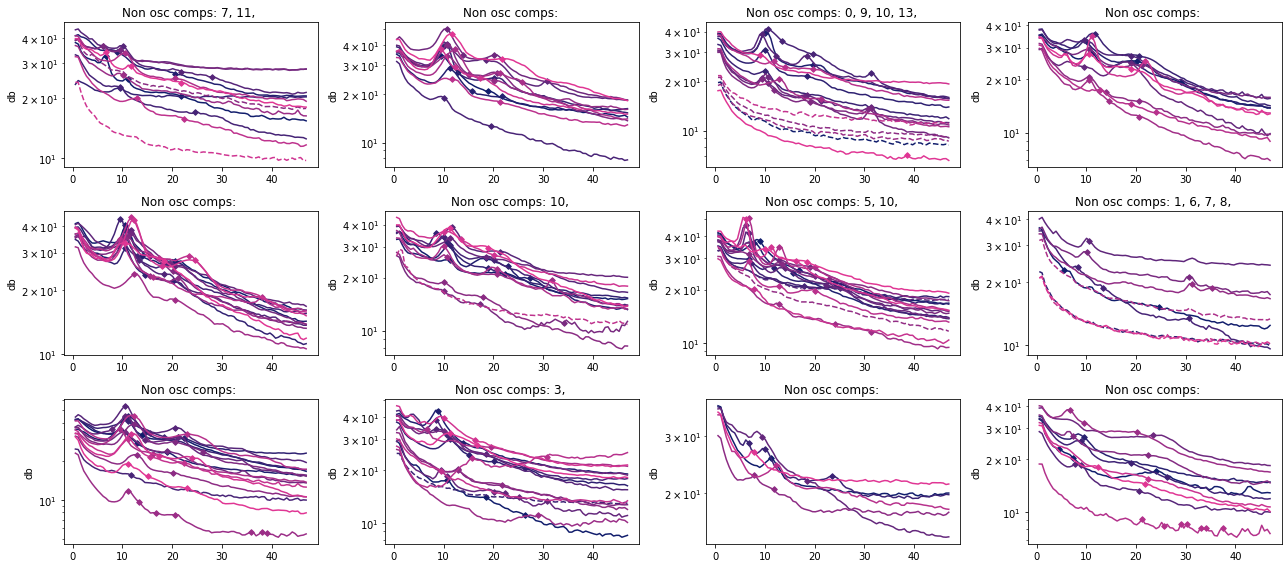

In [10]:
f = plt.figure(figsize=[18,8])
plotFlatComps(comp_data, mark_peak = True) #warning: peak markers are at integer locations so may appear offset

save = 0
if save: f.savefig('./fig/fig', dpi = 300)

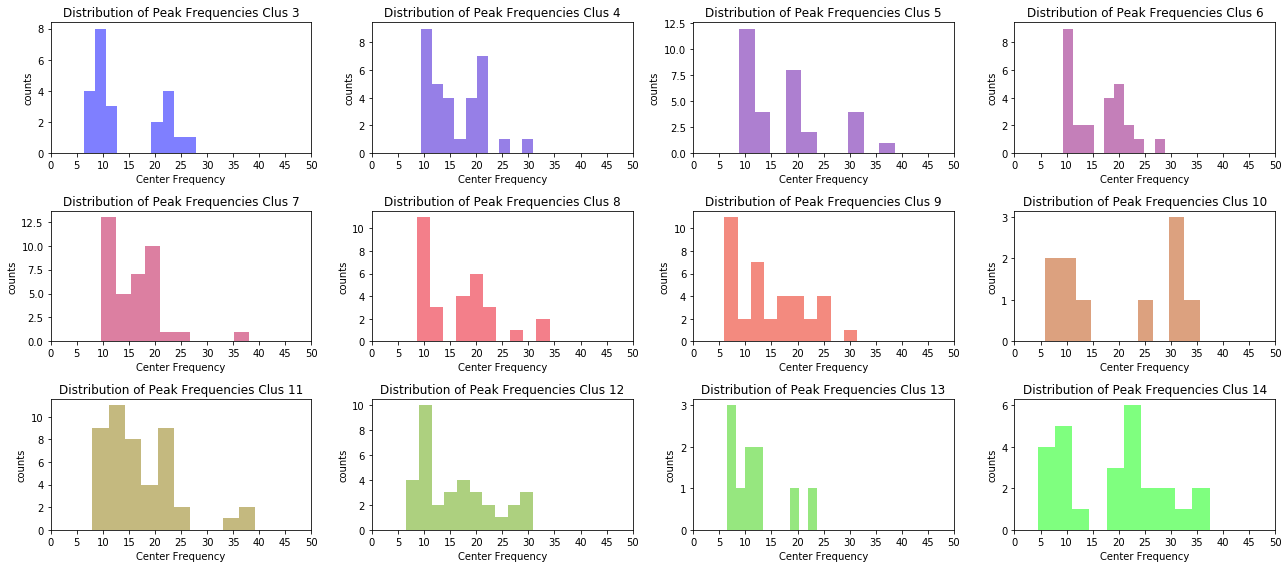

In [22]:
plt.figure(figsize=[18,8])
peakPlot(comp_data, 'CF', plt_format = 'subplots')

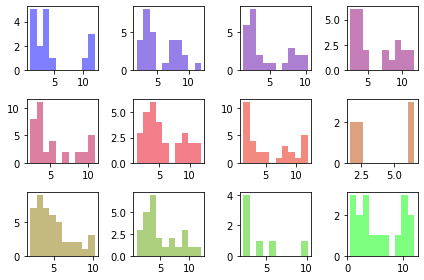

In [5]:
peakPlot(comp_data, 'BW', plt_format = 'subplots')
plt.show()

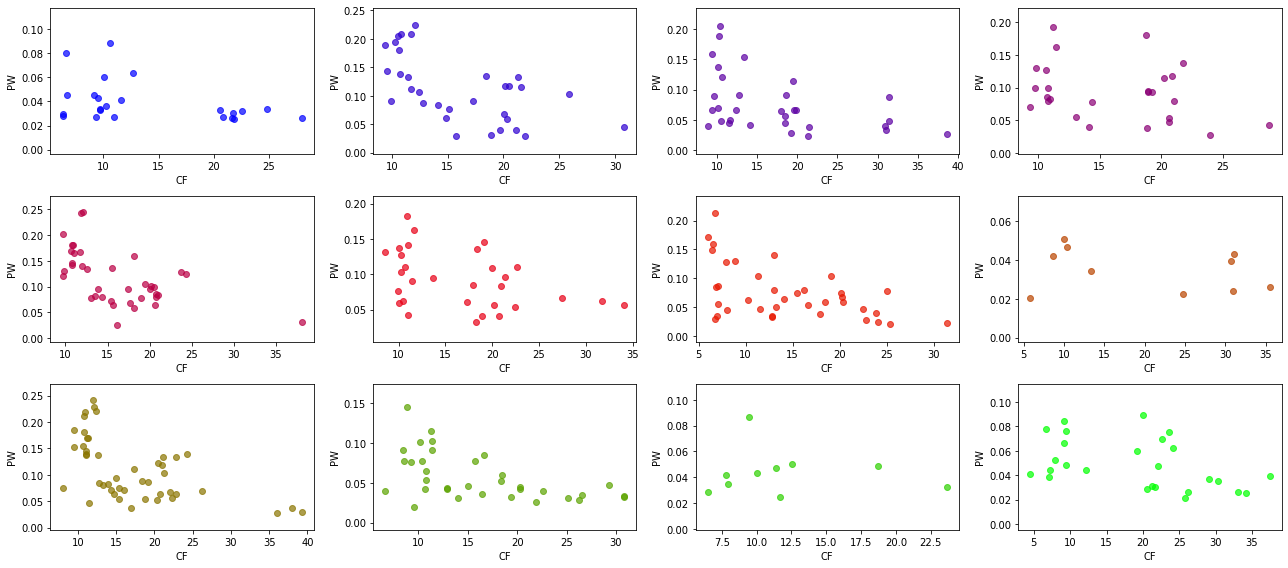

In [7]:
plt.figure(figsize=[18,8])
peakDataScatter(comp_data, measures = ['CF','PW'])

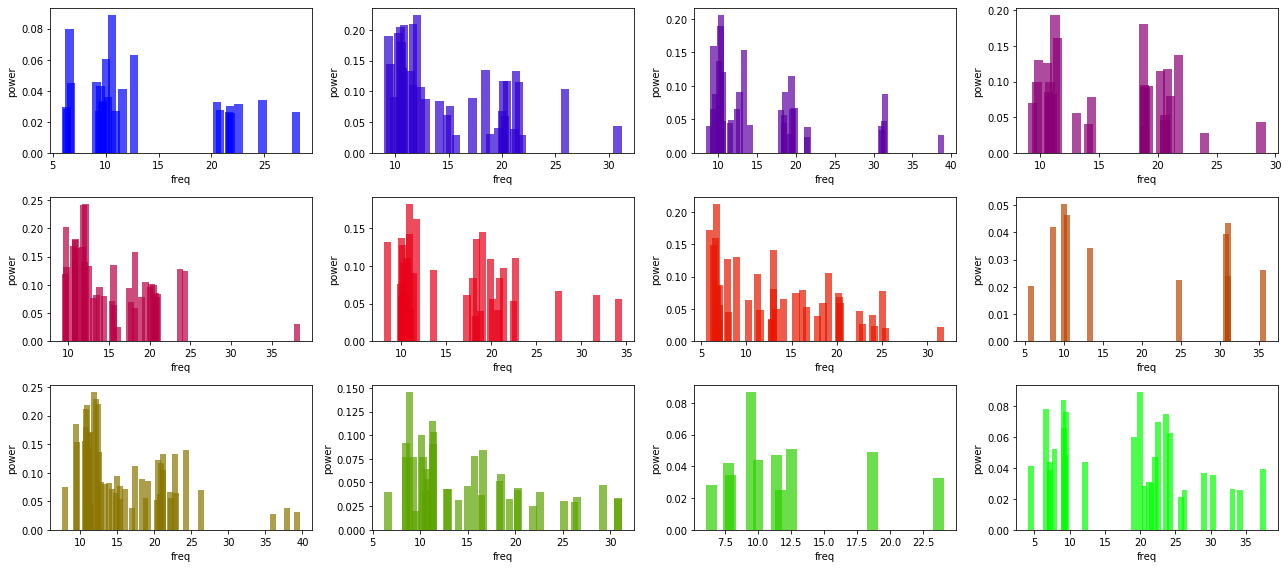

In [6]:
plt.figure(figsize=[18,8])
peakDistr(comp_data)

# Ratio Analysis

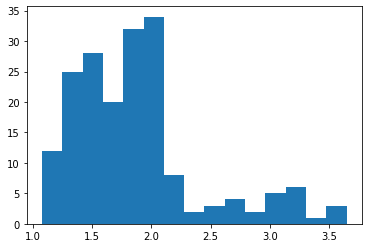

In [12]:
rat, rat_l = calc_ratios(comp_data)
plt.hist(rat_l, bins = 15); plt.show()

# Modality separation
see `id_modes()` in spec_utils.py

In [2]:
alpha_peaks = load_and_fit(dimension = 'condition', freqrange = OSCILLATIONS['alpha'], min_peak_height=0, omit_r2=0.7)
beta_peaks = load_and_fit(dimension = 'condition', freqrange = OSCILLATIONS['beta'], min_peak_height=0, omit_r2=0.7)

Cov:
 [[0.00039163 0.0001763 ]
 [0.0001763  0.00015307]]


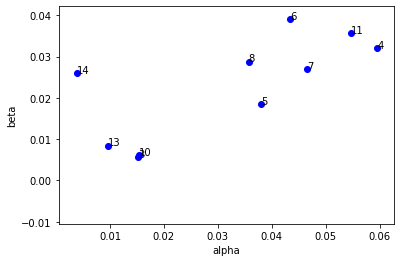

In [60]:
points=[] # alpha, beta
for cl in range(3,15):
    a = np.mean(alpha_peaks[f'cluster {cl}']['peak data']['PW'][:,0])
    b = np.mean(beta_peaks[f'cluster {cl}']['peak data']['PW'][:,0])
    if True not in np.isnan([a,b]):
        points.append([a,b])
    plt.scatter(a,b,color='b')
    plt.annotate(cl, (a,b))
    plt.xlabel('alpha');    plt.ylabel('beta')
    
print(f'Cov:\n {np.cov(np.array(points_clean).T)}')

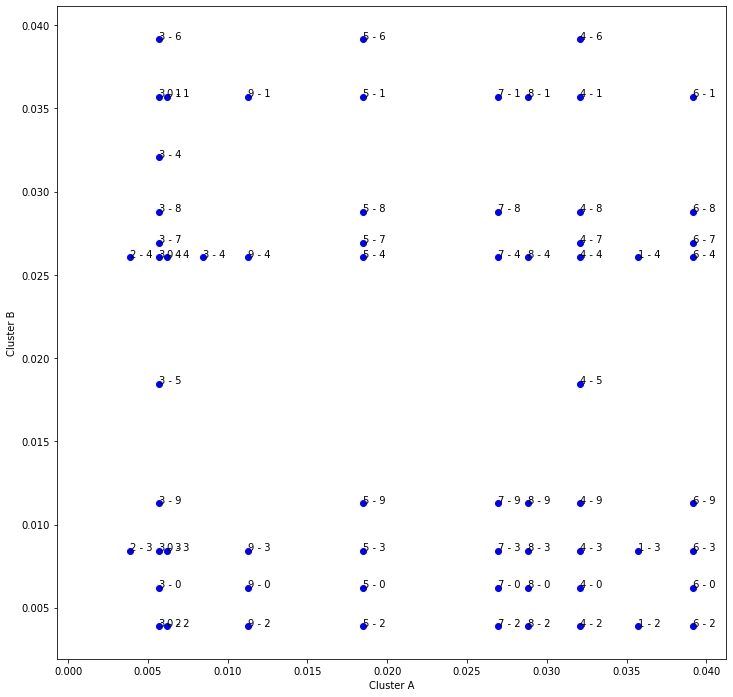

In [62]:
sc = [[],[],[]] #clusA clusB, label

plt.figure(figsize=(12,12))
for ix, co in enumerate(combinations(beta_peaks.keys(), 2)):
    #plt.subplot(11,6,ix+1)
    x = np.mean(beta_peaks[co[0]]['peak data']['PW'][:,0])
    y = np.mean(beta_peaks[co[1]]['peak data']['PW'][:,0])
    sc[0].append(x);    sc[1].append(y);    
    sc[2].append(f'{co[0][-1]} - {co[1][-1]}')
    
    plt.scatter(x,y,color='b')
    plt.annotate(f'{co[0][-1]} - {co[1][-1]}', (x,y))
    plt.xlabel('Cluster A'); plt.ylabel('Cluster B')

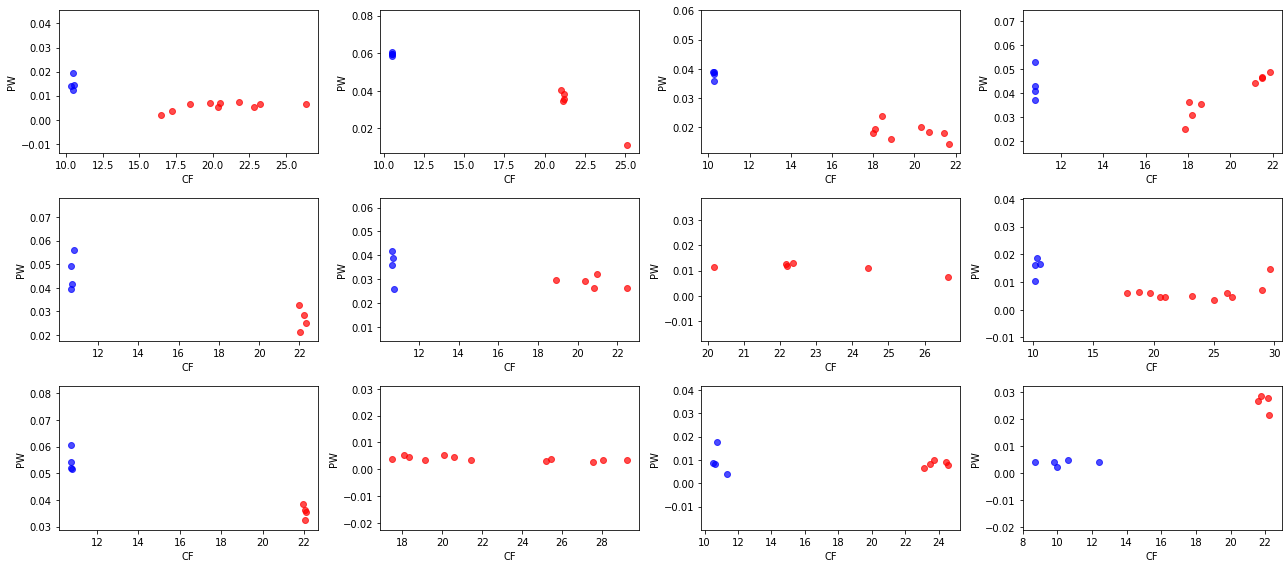

In [59]:
plt.figure(figsize=[18,8])
peakDataScatter(alpha_peaks, measures = ['CF', "PW"])
peakDataScatter(beta_peaks, measures = ['CF', "PW"],color='red')

# Comparison chart
Originally done in MATLAB for ERPs

threshold 0.02

indices: PL, PR, TL, TR

3 statistics: freq, amplitutde, exponent

"Good" peak settingsL
- peak_width_limits=[2,11]
    - more stringent (no side, but removes 9,3,12,10): [5,11]
- peak_threshold = 2.1


In [150]:
cond_data = load_and_fit(dimension = 'condition', freqrange = [3,40], min_peak_height=0.02, omit_r2=0.7, peak_width_limits=[2,11])

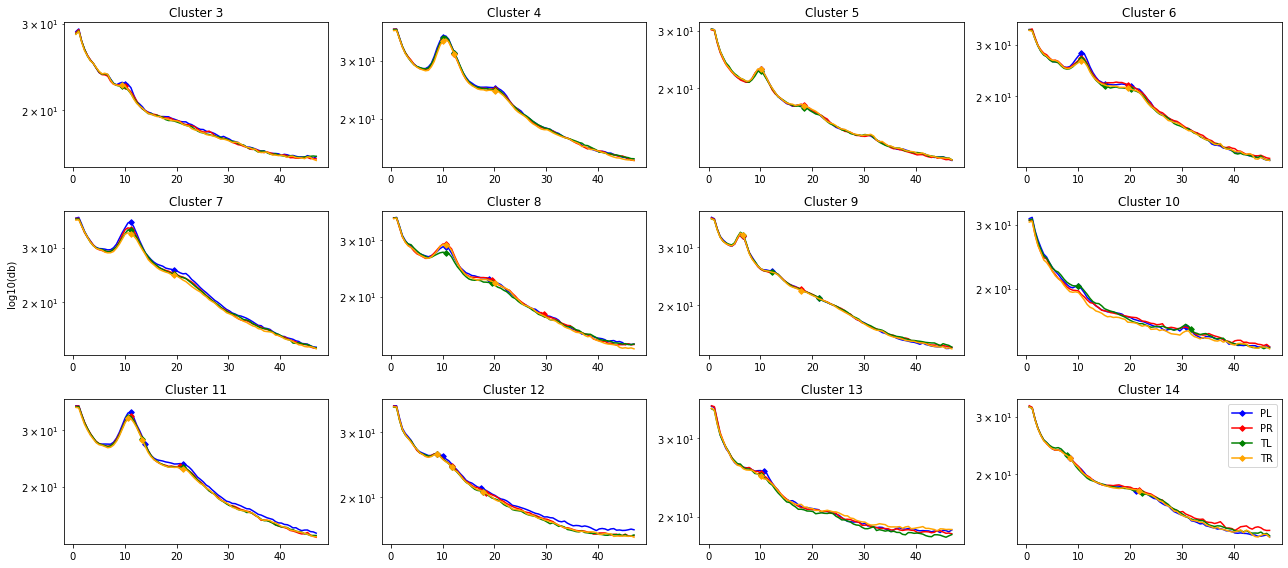

In [151]:
f = plt.figure(figsize=[18,8])
plotFlatComps(cond_data, mark_peak = True, dimension = 'condition')
save = 0
if save: f.savefig('../fig/cond', dpi = 300)

### peaks format should be [freqs, pow, condition]
- though freq differences may be interesting as well

shape is 2 x 8 (2x2 freqs, 2x2 peak diff )

====oscillation: theta
 cl: 9
 [array([0.08026534, 0.        ]), array([0.07719908, 1.        ]), array([0.07803262, 2.        ]), array([0.07693792, 3.        ])]
====oscillation: theta
 cl: 14
 [array([0.03222079, 2.        ])]
====oscillation: alpha
 cl: 9
 [array([0.05037893, 0.        ]), array([0.04455284, 2.        ])]
====oscillation: alpha
 cl: 14
 [array([0.03191004, 0.        ]), array([0.03084176, 1.        ]), array([0.03121053, 3.        ])]
====oscillation: theta-alpha
 cl: 9
 [array([0.08026534, 0.        ]), array([0.05037893, 0.        ]), array([0.07719908, 1.        ]), array([0.07803262, 2.        ]), array([0.04455284, 2.        ]), array([0.07693792, 3.        ])]
====oscillation: theta-alpha
 cl: 14
 [array([0.03191004, 0.        ]), array([0.03084176, 1.        ]), array([0.03222079, 2.        ]), array([0.03121053, 3.        ])]
====oscillation: beta
 cl: 9
 [array([0.04422939, 0.        ]), array([0.0524137, 1.       ]), array([0.03965012, 2.        ]), array

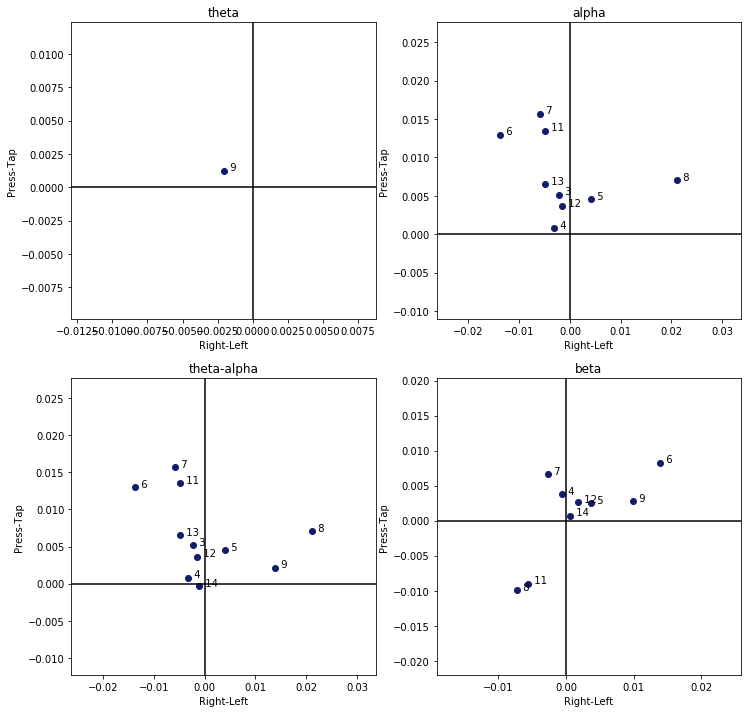

In [176]:
cf_diffs = find_change(cond_data, measure='PW', )

plt.figure(figsize=[12,12])
for i, o in enumerate(cf_diffs.keys()):
    plt.subplot(2,2,i+1)
    x, y = cf_diffs[o]['x'], cf_diffs[o]['y']
    plt.scatter(x,y)
    for t_i, txt in enumerate(cf_diffs[o]['cl']):
        plt.annotate(txt, (x[t_i], y[t_i]))
    plt.axhline(0, color = 'k'); plt.axvline(0, color = 'k')
    #plt.tight_layout()
    plt.title(o)
    plt.xlabel('Right-Left'); plt.ylabel('Press-Tap');

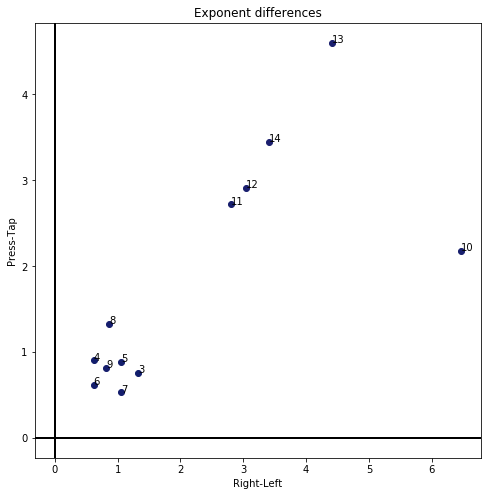

In [159]:
exp_diffs = find_change(cond_data, measure='exponent', change='%')

plt.figure(figsize=[8,8])
for i, cl in enumerate(range(3,15)):
    x, y = exp_diffs['x'][i], exp_diffs['y'][i]
    plt.plot(x,y,marker='o')
    plt.annotate(cl, (x, y))
    plt.axhline(0, color = 'k'); plt.axvline(0, color = 'k')
    plt.title('Exponent differences')
    plt.xlabel('Right-Left'); plt.ylabel('Press-Tap');